In [ ]:
-  !pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rm1000/skin-cancer-isic-images")

Skipping, found downloaded files in "./skin-cancer-isic-images" (use force=True to force download)


In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler,ConcatDataset
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter
from PIL import Image
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
# Fix the path by either using raw string or forward slashes
base_dir = r'C:\Users\acer-\OneDrive - Arab Academy for Science and Technology\Documents\ai project\dataset'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),


])

# Load the dataset
dataset = ImageFolder(base_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print dataset info
print("Number of classes:", len(dataset.classes))
print("Class names:", dataset.classes)



Number of classes: 2
Class names: ['benign', 'malignant']


In [ ]:
# Print the shape of the first batch
for images, labels in dataloader:
    print("Shape of the first batch:", images.shape)
    break

Shape of the first batch: torch.Size([32, 3, 224, 224])


In [ ]:
def visualize_dataset(dataset, num_images=9):
    class_names = dataset.classes
    num_classes = len(class_names)

    # Create subplots for each class
    plt.figure(figsize=(15, 4*num_classes))

    class_images = {class_name: [] for class_name in class_names}
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Collect images for each class
    for image, label in dataloader:
        class_name = class_names[label.item()]
        if len(class_images[class_name]) < num_images:
            class_images[class_name].append(image.squeeze(0).permute(1, 2, 0).numpy())

    # Plot images for each class
    for idx, class_name in enumerate(class_names):
        for i, image in enumerate(class_images[class_name]):
            plt.subplot(num_classes, num_images, idx * num_images + i + 1)
            plt.imshow(image)
            if i == 0:
                plt.title(f'{class_name}', fontsize=10, pad=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_class_distribution(dataset):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}

    # Count images in each class
    for _, label in dataset:
        class_counts[class_names[label]] += 1

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Distribution of Images Across Classes')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print class distribution
    total_images = sum(class_counts.values())
    print("\nClass Distribution:")
    print("-" * 50)
    for class_name, count in class_counts.items():
        percentage = (count / total_images) * 100
        print(f"{class_name}: {count} images ({percentage:.2f}%)")


In [ ]:
def analyze_pixel_distribution(dataset):
    class_names = dataset.classes
    num_classes = len(class_names)

    plt.figure(figsize=(15, 5))

    # Collect pixel values for each class
    for class_idx, class_name in enumerate(class_names):
        pixel_values = []

        # Collect pixel values for the current class
        for image, label in dataset:
            if label == class_idx:
                pixel_values.extend(image.permute(1, 2, 0).reshape(-1).numpy())

        # Plot histogram
        plt.subplot(1, num_classes, class_idx + 1)
        plt.hist(pixel_values, bins=50, density=True, alpha=0.7)
        plt.title(f'Pixel Distribution\n{class_name}')
        plt.xlabel('Pixel Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()



In [ ]:
def print_dataset_stats(dataset):
    print("\nDataset Statistics:")
    print("-" * 50)
    total_images = len(dataset)
    image_shape = dataset[0][0].shape
    print(f"Number of classes: {len(dataset.classes)}")
    print(f"Class names: {dataset.classes}")
    print(f"Total images: {total_images}")
    print(f"Image shape: {image_shape}")
    print(f"Data type: {dataset[0][0].dtype}")

In [ ]:
def count_size_of_class(dataset):

  # Count the size of each class
  class_counts = [0] * len(dataset.classes)

  # Iterate through the dataset to count images per class
  for _, label in dataset:
      class_counts[label] += 1

  # Print the counts for each class
  for i, class_name in enumerate(dataset.classes):
      print(f"Class '{class_name}': {class_counts[i]} images")


Running dataset analysis...

Dataset Statistics:
--------------------------------------------------
Number of classes: 2
Class names: ['benign', 'malignant']
Total images: 3297
Image shape: torch.Size([3, 224, 224])
Data type: torch.float32


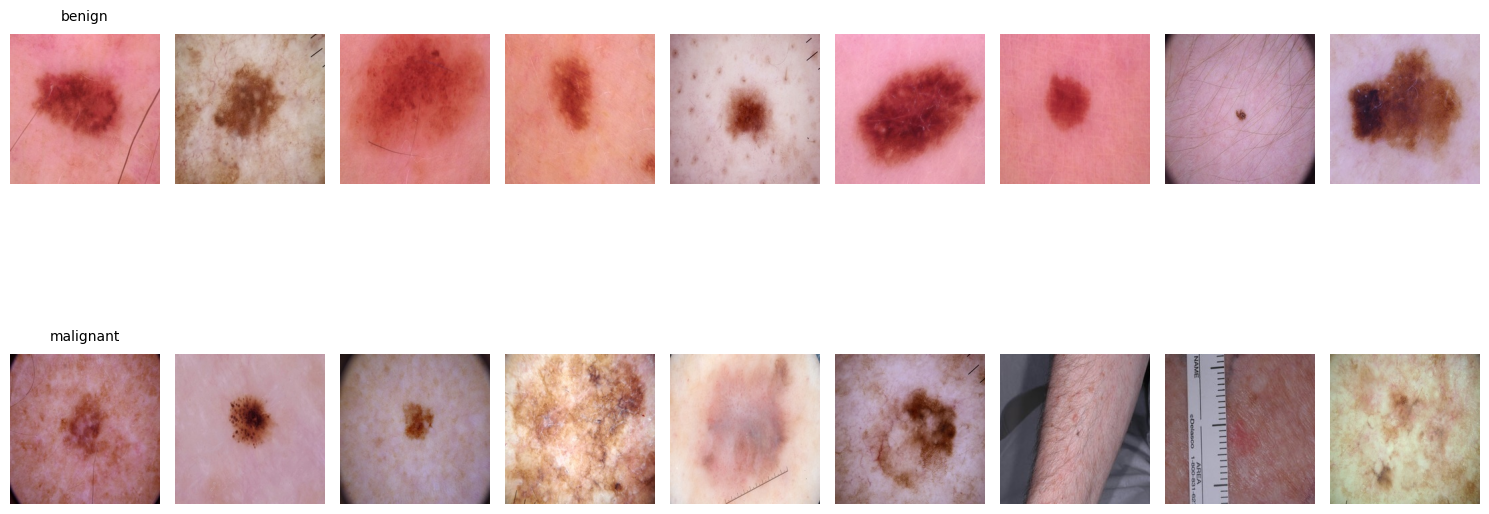

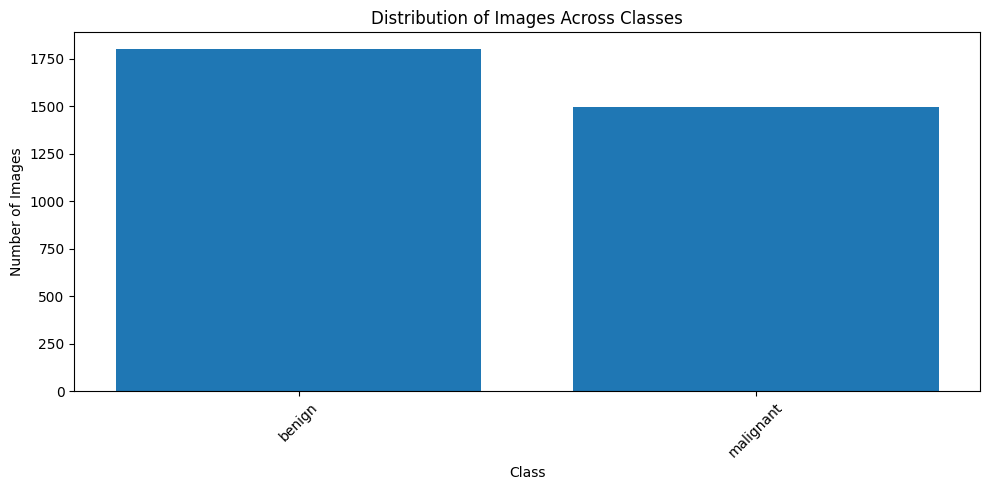


Class Distribution:
--------------------------------------------------
benign: 1800 images (54.60%)
malignant: 1497 images (45.40%)
Class 'benign': 1800 images
Class 'malignant': 1497 images


In [ ]:
# Run all analyses
print("Running dataset analysis...")
print_dataset_stats(dataset)
visualize_dataset(dataset)
analyze_class_distribution(dataset)
count_size_of_class(dataset)
#analyze_pixel_distribution(dataset)

In [ ]:
img_size = (224, 224)
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(),
        transforms.ToTensor(),

])

In [ ]:
# Create a list to hold augmented images
augmented_images = []

# Generate multiple augmented images for each sample
num_augmentations = 5  # Increase the dataset size by creating 5 augmented versions per image
# Generate augmented images
for img, label in dataset:
  # Convert the tensor back to a PIL Image
    img_pil = transforms.ToPILImage()(img)
    for _ in range(num_augmentations):
        # Apply the augmentation transformation
        augmented_img = augmentation_transform(img_pil)

        # Store the augmented image and its label
        augmented_images.append((augmented_img, label))

# Create a dataset from the augmented images
augmented_dataset = [(aug_img, label) for aug_img, label in augmented_images]

# Combine original and augmented datasets
combined_dataset = ConcatDataset([dataset, augmented_dataset])

# Create a DataLoader
combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)


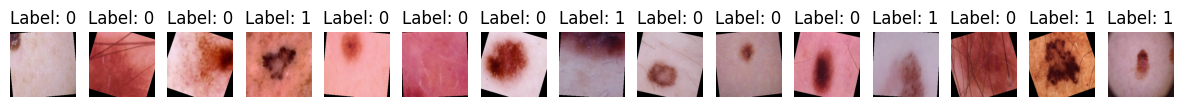

In [ ]:
# Function to convert a tensor to a NumPy array
def tensor_to_numpy(img_tensor):
    # Denormalize if required, then convert to numpy
    img = img_tensor.permute(1, 2, 0).numpy()
    return np.clip(img, 0, 1)

# Get a batch of images from the dataloader
data_iter = iter(combined_dataloader)
images, labels = next(data_iter)

# Plot a few images from the batch
num_images = 15  # Number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(15, 6))

for i in range(num_images):
    img = tensor_to_numpy(images[i])
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i].item()}')

plt.show()

Class Distribution in Original Dataset:
Counter({0: 1800, 1: 1497})
Class Distribution in Augmented Dataset:
Counter({0: 9000, 1: 7485})
Class Distribution in Combined Dataset:
{0: 10800, 1: 8982}


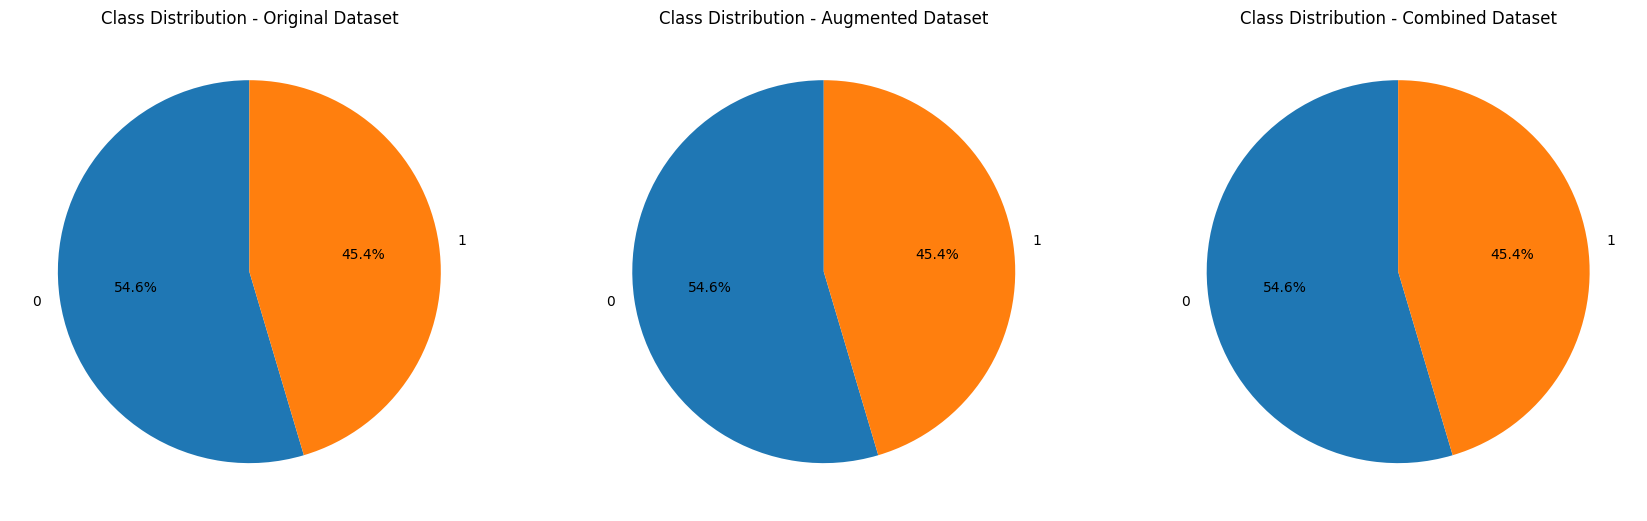

In [ ]:
# Function to compute class distribution
def get_class_distribution(dataset):
    labels = [label for _, label in dataset]
    return Counter(labels)

# Get class distributions for both original and augmented datasets
original_class_distribution = get_class_distribution(dataset)
augmented_class_distribution = get_class_distribution(augmented_dataset)

# Combine the class distributions from original and augmented datasets
combined_class_distribution = {key: original_class_distribution.get(key, 0) + augmented_class_distribution.get(key, 0)
                               for key in set(original_class_distribution) | set(augmented_class_distribution)}

# Plot the pie chart for original dataset distribution
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Original dataset distribution pie chart
axes[0].pie(original_class_distribution.values(), labels=original_class_distribution.keys(), autopct='%1.1f%%', startangle=90)
axes[0].set_title('Class Distribution - Original Dataset')

# Print the class distributions
print("Class Distribution in Original Dataset:")
print(original_class_distribution)

# Augmented dataset distribution pie chart
axes[1].pie(augmented_class_distribution.values(), labels=augmented_class_distribution.keys(), autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution - Augmented Dataset')

print("Class Distribution in Augmented Dataset:")
print(augmented_class_distribution)

# Combined dataset distribution pie chart
axes[2].pie(combined_class_distribution.values(), labels=combined_class_distribution.keys(), autopct='%1.1f%%', startangle=90)
axes[2].set_title('Class Distribution - Combined Dataset')

print("Class Distribution in Combined Dataset:")
print(combined_class_distribution)
# Display the pie charts
plt.show()

In [ ]:
def get_labels_from_dataset(dataset):
    return [sample[1] for sample in dataset]  # Assuming label is the second element

all_labels = get_labels_from_dataset(combined_dataset)

# Calculate class distribution
class_counts = Counter(all_labels)
num_classes = len(class_counts)
total_samples = len(all_labels)

# Compute class weights
class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
weights = [class_weights[label] for label in all_labels]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
# Extract the sampled indices
balanced_indices = list(sampler)

# Create a Subset for the balanced dataset
balanced_dataset = Subset(combined_dataset, balanced_indices)
# Create a DataLoader with the sampler
balanced_dataloader = DataLoader(combined_dataset, batch_size=32, sampler=sampler)

all_labels_balanced = get_labels_from_dataset(balanced_dataset)
# Calculate class distribution
balanced_class_counts = Counter(all_labels_balanced)
num_classes = len(balanced_class_counts)
total_samples = len(all_labels_balanced)

In [ ]:
# Print dataset sizes
print(f"Total original Dataset Size: {len(dataset)}")
print(f"Balanced Dataset Size: {len(balanced_dataset)}")
print("Class Sizes in Balanced Dataset:")
for cls, count in balanced_class_counts.items():
    print(f"Class {cls}: {count}")

Total original Dataset Size: 3297
Balanced Dataset Size: 19782
Class Sizes in Balanced Dataset:
Class 0: 9894
Class 1: 9888


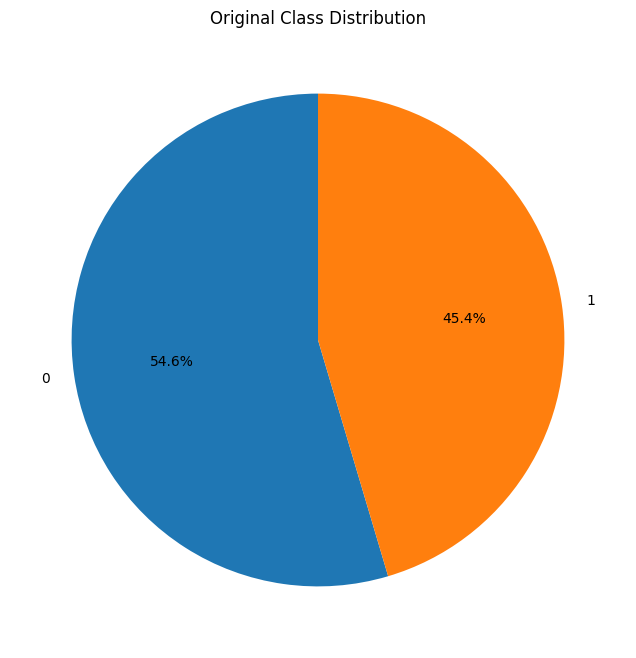

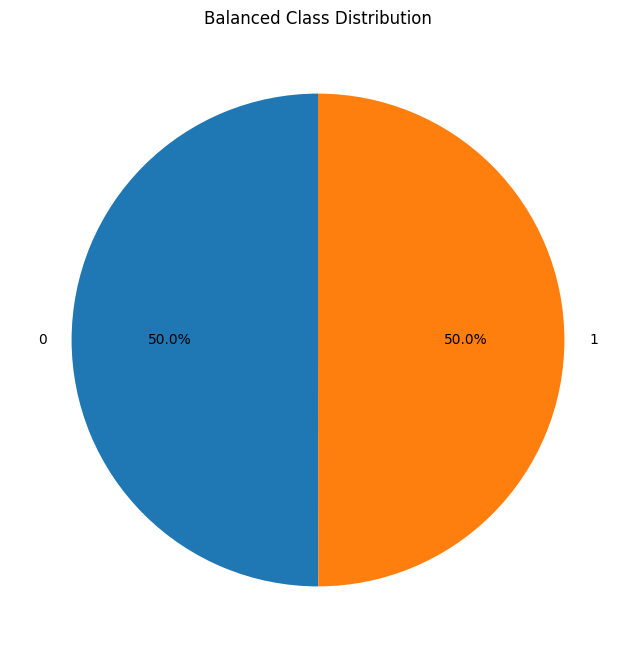

In [ ]:
def plot_class_distribution(class_counts, title):
    labels = list(class_counts.keys())
    sizes = list(class_counts.values())
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%',  startangle=90)
    plt.title(title)
    plt.show()

plot_class_distribution(class_counts, "Original Class Distribution")
plot_class_distribution(balanced_class_counts, "Balanced Class Distribution")

In [ ]:
# Parameters
img_size = (224, 224)
batch_size = 64
epochs = 20
learning_rate = 0.0001
num_folds = 5
patience = 5  # Number of epochs to wait for improvement before stopping
dataset_dir = base_dir

In [ ]:
# Cross-Validation Setup
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [ ]:
# Ensure GPU memory management is optimal
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class HandcraftedCNN(nn.Module):
    def __init__(self, device):
        super(HandcraftedCNN, self).__init__()

        # First convolutional block
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Second convolutional block
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Third convolutional block
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fourth convolutional block
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        # Flatten size: 256 channels * 14 * 14 = 50176 for 224x224 input
        self.fc = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        # Move model to device
        self.to(device)

    def forward(self, x):
        # Pass through convolutional blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc(x)

        return x

In [ ]:
# Create model instance
model = HandcraftedCNN(device)

C:\Users\acer-\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\module.py:1160: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


In [ ]:
# Training and evaluation
def train_and_evaluate1(train_indices, val_indices, test_indices, fold):
    print(f"Starting Fold {fold + 1}/{num_folds}")
    metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Create subsets
    train_subset = Subset(balanced_dataset, train_indices)
    val_subset = Subset(balanced_dataset, val_indices)
    test_subset = Subset(balanced_dataset, test_indices)

    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


    # Loss and optimizer
  # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)
    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.3, verbose=True)






    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):  # Number of epochs
        # Training

        model.train()
        train_loss = 0.0
        train_correct, train_total = 0, 0
        with tqdm(total=len(train_loader), desc=f"Fold {fold + 1} Epoch {epoch + 1} - Training", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                optimizer.zero_grad()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()

                 # Apply gradient clipping
                #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                train_loss += loss.item()
                preds = (outputs > 0.5).float()
                train_correct += (preds == labels).sum().item()
                train_total += labels.size(0)

                pbar.set_postfix(loss=train_loss / len(train_loader), acc=100. * train_correct / train_total)
                pbar.update(1)

        train_accuracy = 100. * train_correct / train_total
        metrics['train_loss'].append(train_loss / len(train_loader))
        metrics['train_acc'].append(train_accuracy)

        # Validation
        #conv1_3x3.eval()
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = 100. * val_correct / val_total
        metrics['val_loss'].append(val_loss / len(val_loader))
        metrics['val_acc'].append(val_accuracy)

        print(f"Epoch {epoch + 1} - Train Loss: {metrics['train_loss'][-1]:.4f}, Train Acc: {metrics['train_acc'][-1]:.2f}%, Val Loss: {metrics['val_loss'][-1]:.4f}, Val Acc: {metrics['val_acc'][-1]:.2f}%")

        # Step the scheduler
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model_crafted_fold_{fold}.pth')
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
            print(f"Early Stopping Patience Counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch + 1} for Fold {fold + 1}")
            break

    # Plot accuracy and loss graphs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold + 1} Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['val_acc'], label='Val Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.legend()
    plt.show()

    # Evaluate on test set
   # vgg_conv1.eval()
    model.eval()
    test_correct, test_total = 0, 0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            preds = (outputs > 0.5).float()
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_accuracy = 100. * test_correct / test_total
    print(f"Fold {fold + 1} - Test Accuracy: {test_accuracy:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    print(f"Confusion Matrix for Fold {fold + 1}:\n", cm)
    print(f"Classification Report for Fold {fold + 1}:\n", classification_report(test_labels, test_preds))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [ ]:
# Split dataset into train+val and test
train_val_indices, test_indices = train_test_split(list(range(len(balanced_dataset))), test_size=0.2, random_state=42)
print(len(train_val_indices),len(test_indices))

15825 3957


C:\Users\acer-\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting Fold 1/5


Fold 1 Epoch 1 - Training: 100%|████████████████████████████| 198/198 [00:42<00:00,  4.71batch/s, acc=67.3, loss=0.574]


Epoch 1 - Train Loss: 0.5737, Train Acc: 67.28%, Val Loss: 0.4524, Val Acc: 79.91%


Fold 1 Epoch 2 - Training: 100%|████████████████████████████| 198/198 [00:44<00:00,  4.42batch/s, acc=78.9, loss=0.457]


Epoch 2 - Train Loss: 0.4567, Train Acc: 78.89%, Val Loss: 0.4257, Val Acc: 80.51%


Fold 1 Epoch 3 - Training: 100%|████████████████████████████| 198/198 [00:46<00:00,  4.21batch/s, acc=79.9, loss=0.437]


Epoch 3 - Train Loss: 0.4366, Train Acc: 79.89%, Val Loss: 0.4107, Val Acc: 80.88%


Fold 1 Epoch 4 - Training: 100%|████████████████████████████| 198/198 [00:47<00:00,  4.17batch/s, acc=80.8, loss=0.413]


Epoch 4 - Train Loss: 0.4134, Train Acc: 80.84%, Val Loss: 0.3967, Val Acc: 81.20%


Fold 1 Epoch 5 - Training: 100%|██████████████████████████████| 198/198 [00:46<00:00,  4.23batch/s, acc=81, loss=0.405]


Epoch 5 - Train Loss: 0.4052, Train Acc: 80.96%, Val Loss: 0.3879, Val Acc: 81.86%


Fold 1 Epoch 6 - Training: 100%|████████████████████████████| 198/198 [00:46<00:00,  4.22batch/s, acc=80.9, loss=0.409]


Epoch 6 - Train Loss: 0.4087, Train Acc: 80.91%, Val Loss: 0.3914, Val Acc: 81.48%
Early Stopping Patience Counter: 1/5


Fold 1 Epoch 7 - Training: 100%|████████████████████████████| 198/198 [00:47<00:00,  4.19batch/s, acc=81.9, loss=0.389]


Epoch 7 - Train Loss: 0.3888, Train Acc: 81.90%, Val Loss: 0.3826, Val Acc: 82.15%


Fold 1 Epoch 8 - Training: 100%|████████████████████████████| 198/198 [00:47<00:00,  4.14batch/s, acc=82.4, loss=0.385]


Epoch 8 - Train Loss: 0.3849, Train Acc: 82.44%, Val Loss: 0.3816, Val Acc: 82.05%


Fold 1 Epoch 9 - Training: 100%|████████████████████████████| 198/198 [00:47<00:00,  4.18batch/s, acc=82.7, loss=0.375]


Epoch 9 - Train Loss: 0.3753, Train Acc: 82.67%, Val Loss: 0.3722, Val Acc: 82.34%


Fold 1 Epoch 10 - Training: 100%|███████████████████████████| 198/198 [00:46<00:00,  4.22batch/s, acc=83.1, loss=0.368]


Epoch 10 - Train Loss: 0.3678, Train Acc: 83.08%, Val Loss: 0.3625, Val Acc: 82.72%


Fold 1 Epoch 11 - Training: 100%|███████████████████████████| 198/198 [00:46<00:00,  4.22batch/s, acc=83.8, loss=0.359]


Epoch 11 - Train Loss: 0.3588, Train Acc: 83.79%, Val Loss: 0.3497, Val Acc: 83.38%


Fold 1 Epoch 12 - Training: 100%|███████████████████████████| 198/198 [00:47<00:00,  4.17batch/s, acc=84.4, loss=0.345]


Epoch 12 - Train Loss: 0.3447, Train Acc: 84.35%, Val Loss: 0.3505, Val Acc: 82.97%
Early Stopping Patience Counter: 1/5


Fold 1 Epoch 13 - Training: 100%|███████████████████████████| 198/198 [00:47<00:00,  4.18batch/s, acc=84.4, loss=0.339]


Epoch 13 - Train Loss: 0.3388, Train Acc: 84.36%, Val Loss: 0.3406, Val Acc: 84.17%


Fold 1 Epoch 14 - Training: 100%|████████████████████████████| 198/198 [00:49<00:00,  4.03batch/s, acc=84.6, loss=0.33]


Epoch 14 - Train Loss: 0.3301, Train Acc: 84.64%, Val Loss: 0.3268, Val Acc: 84.90%


Fold 1 Epoch 15 - Training: 100%|███████████████████████████| 198/198 [00:48<00:00,  4.08batch/s, acc=84.8, loss=0.325]


Epoch 15 - Train Loss: 0.3254, Train Acc: 84.79%, Val Loss: 0.3224, Val Acc: 85.28%


Fold 1 Epoch 16 - Training: 100%|███████████████████████████| 198/198 [00:48<00:00,  4.09batch/s, acc=85.1, loss=0.321]


Epoch 16 - Train Loss: 0.3214, Train Acc: 85.09%, Val Loss: 0.3229, Val Acc: 84.83%
Early Stopping Patience Counter: 1/5


Fold 1 Epoch 17 - Training: 100%|███████████████████████████| 198/198 [00:47<00:00,  4.15batch/s, acc=85.9, loss=0.309]


Epoch 17 - Train Loss: 0.3094, Train Acc: 85.86%, Val Loss: 0.3384, Val Acc: 84.30%
Early Stopping Patience Counter: 2/5


Fold 1 Epoch 18 - Training: 100%|███████████████████████████| 198/198 [00:47<00:00,  4.17batch/s, acc=86.2, loss=0.304]


Epoch 18 - Train Loss: 0.3035, Train Acc: 86.23%, Val Loss: 0.3289, Val Acc: 84.01%
Early Stopping Patience Counter: 3/5


Fold 1 Epoch 19 - Training: 100%|█████████████████████████████| 198/198 [00:49<00:00,  4.00batch/s, acc=86, loss=0.303]


Epoch 19 - Train Loss: 0.3033, Train Acc: 85.98%, Val Loss: 0.3332, Val Acc: 84.42%
Early Stopping Patience Counter: 4/5


Fold 1 Epoch 20 - Training: 100%|███████████████████████████| 198/198 [00:48<00:00,  4.10batch/s, acc=87.4, loss=0.277]


Epoch 20 - Train Loss: 0.2766, Train Acc: 87.39%, Val Loss: 0.2961, Val Acc: 86.70%


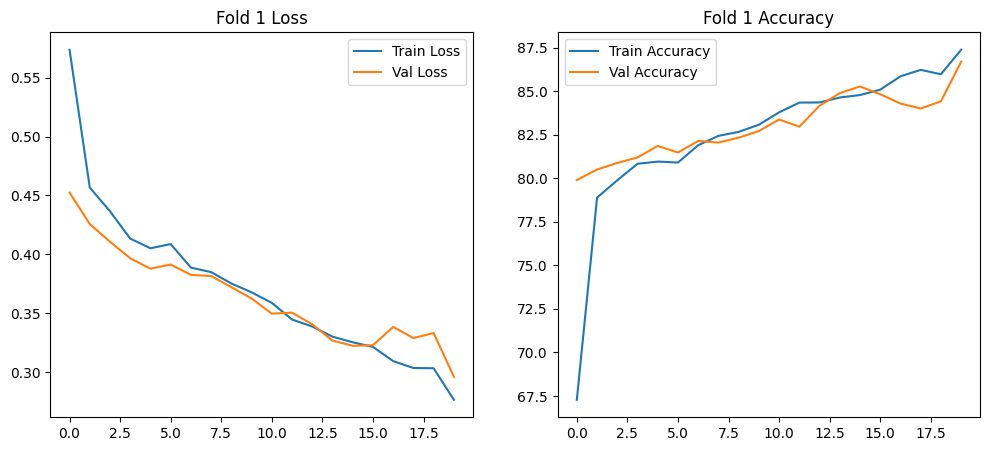

Fold 1 - Test Accuracy: 87.29%
Confusion Matrix for Fold 1:
 [[1651  330]
 [ 173 1803]]
Classification Report for Fold 1:
               precision    recall  f1-score   support

         0.0       0.91      0.83      0.87      1981
         1.0       0.85      0.91      0.88      1976

    accuracy                           0.87      3957
   macro avg       0.88      0.87      0.87      3957
weighted avg       0.88      0.87      0.87      3957



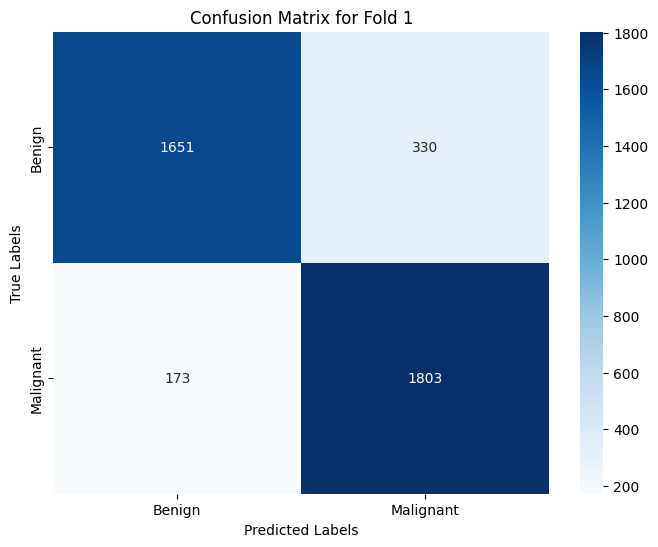

C:\Users\acer-\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting Fold 2/5


Fold 2 Epoch 1 - Training: 100%|████████████████████████████| 198/198 [00:49<00:00,  3.98batch/s, acc=86.7, loss=0.298]


Epoch 1 - Train Loss: 0.2976, Train Acc: 86.68%, Val Loss: 0.2673, Val Acc: 87.65%


Fold 2 Epoch 2 - Training: 100%|████████████████████████████| 198/198 [00:49<00:00,  4.04batch/s, acc=87.2, loss=0.289]


Epoch 2 - Train Loss: 0.2887, Train Acc: 87.19%, Val Loss: 0.2635, Val Acc: 88.28%


Fold 2 Epoch 3 - Training: 100%|████████████████████████████| 198/198 [00:49<00:00,  3.97batch/s, acc=87.9, loss=0.273]


Epoch 3 - Train Loss: 0.2728, Train Acc: 87.87%, Val Loss: 0.2568, Val Acc: 88.56%


Fold 2 Epoch 4 - Training: 100%|████████████████████████████| 198/198 [00:50<00:00,  3.93batch/s, acc=88.4, loss=0.264]


Epoch 4 - Train Loss: 0.2636, Train Acc: 88.37%, Val Loss: 0.2622, Val Acc: 88.31%
Early Stopping Patience Counter: 1/5


Fold 2 Epoch 5 - Training: 100%|████████████████████████████| 198/198 [00:52<00:00,  3.78batch/s, acc=89.6, loss=0.248]


Epoch 5 - Train Loss: 0.2482, Train Acc: 89.57%, Val Loss: 0.2733, Val Acc: 87.87%
Early Stopping Patience Counter: 2/5


Fold 2 Epoch 6 - Training: 100%|█████████████████████████████| 198/198 [00:52<00:00,  3.80batch/s, acc=90.3, loss=0.23]


Epoch 6 - Train Loss: 0.2303, Train Acc: 90.32%, Val Loss: 0.2488, Val Acc: 89.16%


Fold 2 Epoch 7 - Training: 100%|████████████████████████████| 198/198 [00:49<00:00,  3.98batch/s, acc=90.6, loss=0.222]


Epoch 7 - Train Loss: 0.2223, Train Acc: 90.65%, Val Loss: 0.2431, Val Acc: 89.38%


Fold 2 Epoch 8 - Training: 100%|████████████████████████████| 198/198 [00:48<00:00,  4.05batch/s, acc=91.6, loss=0.204]


Epoch 8 - Train Loss: 0.2038, Train Acc: 91.60%, Val Loss: 0.2707, Val Acc: 87.84%
Early Stopping Patience Counter: 1/5


Fold 2 Epoch 9 - Training: 100%|████████████████████████████| 198/198 [00:49<00:00,  3.98batch/s, acc=92.8, loss=0.182]


Epoch 9 - Train Loss: 0.1816, Train Acc: 92.83%, Val Loss: 0.2343, Val Acc: 90.08%


Fold 2 Epoch 10 - Training: 100%|███████████████████████████| 198/198 [00:49<00:00,  4.03batch/s, acc=93.6, loss=0.165]


Epoch 10 - Train Loss: 0.1646, Train Acc: 93.59%, Val Loss: 0.2327, Val Acc: 90.08%


Fold 2 Epoch 11 - Training: 100%|███████████████████████████| 198/198 [00:49<00:00,  3.98batch/s, acc=94.4, loss=0.143]


Epoch 11 - Train Loss: 0.1430, Train Acc: 94.39%, Val Loss: 0.2400, Val Acc: 91.34%
Early Stopping Patience Counter: 1/5


Fold 2 Epoch 12 - Training: 100%|███████████████████████████| 198/198 [00:49<00:00,  4.03batch/s, acc=95.4, loss=0.132]


Epoch 12 - Train Loss: 0.1316, Train Acc: 95.36%, Val Loss: 0.2463, Val Acc: 91.28%
Early Stopping Patience Counter: 2/5


Fold 2 Epoch 13 - Training: 100%|█████████████████████████████| 198/198 [00:48<00:00,  4.09batch/s, acc=96, loss=0.108]


Epoch 13 - Train Loss: 0.1084, Train Acc: 95.99%, Val Loss: 0.2645, Val Acc: 91.72%
Early Stopping Patience Counter: 3/5


Fold 2 Epoch 14 - Training: 100%|██████████████████████████| 198/198 [00:48<00:00,  4.11batch/s, acc=96.8, loss=0.0921]


Epoch 14 - Train Loss: 0.0921, Train Acc: 96.82%, Val Loss: 0.2529, Val Acc: 90.68%
Early Stopping Patience Counter: 4/5


Fold 2 Epoch 15 - Training: 100%|██████████████████████████| 198/198 [00:48<00:00,  4.11batch/s, acc=98.2, loss=0.0597]


Epoch 15 - Train Loss: 0.0597, Train Acc: 98.17%, Val Loss: 0.2589, Val Acc: 92.07%
Early Stopping Patience Counter: 5/5
Stopping early at epoch 15 for Fold 2


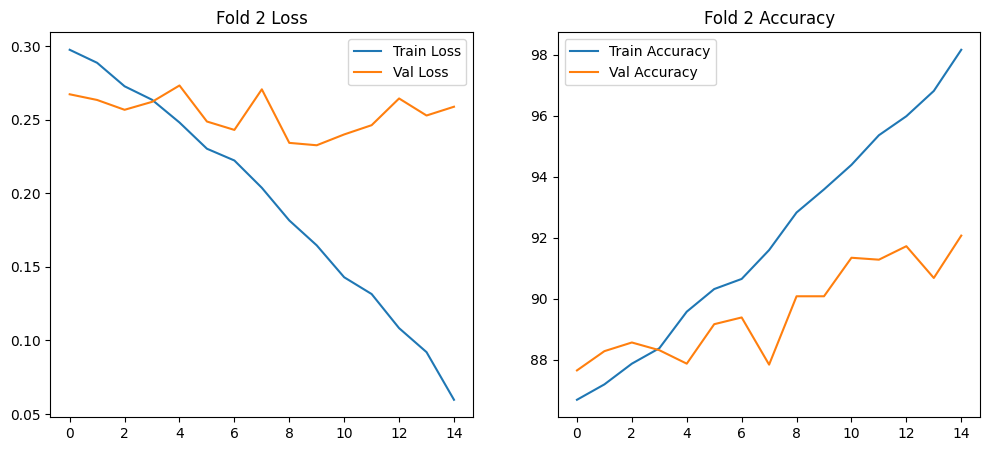

Fold 2 - Test Accuracy: 95.60%
Confusion Matrix for Fold 2:
 [[1868  113]
 [  61 1915]]
Classification Report for Fold 2:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      1981
         1.0       0.94      0.97      0.96      1976

    accuracy                           0.96      3957
   macro avg       0.96      0.96      0.96      3957
weighted avg       0.96      0.96      0.96      3957



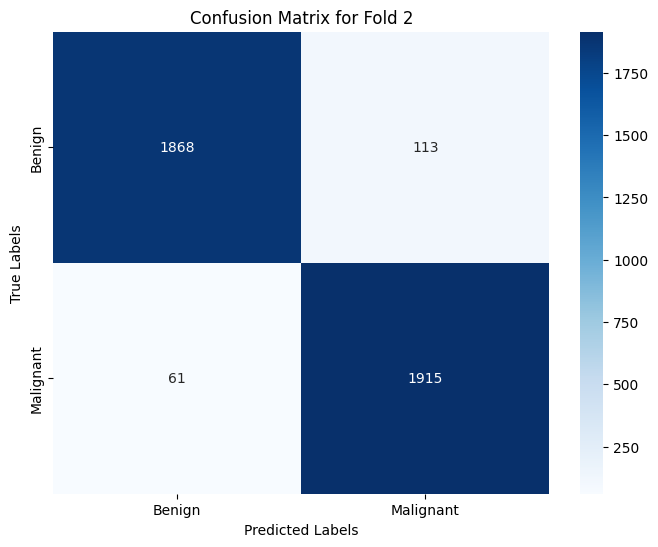

Starting Fold 3/5

C:\Users\acer-\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 3 Epoch 1 - Training: 100%|████████████████████████████| 198/198 [00:50<00:00,  3.92batch/s, acc=95.3, loss=0.129]


Epoch 1 - Train Loss: 0.1293, Train Acc: 95.33%, Val Loss: 0.0830, Val Acc: 98.10%


Fold 3 Epoch 2 - Training: 100%|███████████████████████████| 198/198 [00:53<00:00,  3.67batch/s, acc=96.7, loss=0.0993]


Epoch 2 - Train Loss: 0.0993, Train Acc: 96.67%, Val Loss: 0.0614, Val Acc: 97.91%


Fold 3 Epoch 3 - Training:  86%|████████████████████████    | 170/198 [00:46<00:07,  3.67batch/s, acc=97.3, loss=0.071]


KeyboardInterrupt: 

In [ ]:
# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_indices)):
    train_and_evaluate1(train_idx, val_idx, test_indices, fold)

In [ ]:

# Now you can use summary
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
            Conv2d-3         [-1, 32, 224, 224]           9,248
              ReLU-4         [-1, 32, 224, 224]               0
         MaxPool2d-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          18,496
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,928
              ReLU-9         [-1, 64, 112, 112]               0
        MaxPool2d-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
             ReLU-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]         147,584
             ReLU-14          [-1, 128,